# Experiment

## Import libs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys,inspect
#sys.path.insert(0,"..")
os.chdir('..')

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torch.autograd import Variable

import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
random.seed(0)
os.environ['PYTHONHASHSEED'] = str(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# EXPERIMENT_NAME = "exp"

# ROOT_DIR = os.path.abspath(".")
# LOG_PATH = os.path.join(ROOT_DIR, "logs", EXPERIMENT_NAME)

# if not os.path.exists(LOG_PATH):
#     os.mkdir(LOG_PATH)

cuda:0


## Load data

In [4]:
from dataset import ISIC2018_dataloader

train_dataset = ISIC2018_dataloader("datasets/ISIC2018")
test_dataset = ISIC2018_dataloader("datasets/ISIC2018", is_train=False)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=8)

In [5]:
dt = next(iter(train_dataloader))
x = dt["image"]
y = dt["mask"]
x.shape, y.shape

(torch.Size([16, 3, 256, 256]), torch.Size([16, 1, 256, 256]))

(256, 256, 3)


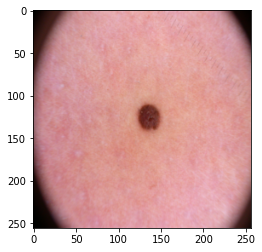

In [6]:
def to_img(ten):
    ten =(ten[0].permute(1,2,0).detach().cpu().numpy()+1)/2
    ten=(ten*255).astype(np.uint8)
    return ten

a = to_img(x)
print(a.shape)
plt.imshow(a)
#plt.imshow(a, cmap='gray')

## Load model

In [8]:
from models import * 

# Define model
model = ODOC_seg_edge()
#model = build_resnet50_unet()

# Send to GPU and initialize weights
model = model.to(DEVICE)
#model.apply(weights_init)

In [9]:
# All parameters
all_params = sum(p.numel() for p in model.parameters())
print("All parameters ", all_params)

# Trainable parameters
all_train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable parameters ", all_train_params)

All parameters  35970659
Trainable parameters  35970659


In [10]:
x.shape

torch.Size([16, 3, 256, 256])

In [11]:
pred = model(x.cuda())
pred.shape

/home/hasib/anaconda3/envs/fifa/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


torch.Size([16, 1, 256, 256])

## Setup optim and loss

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss() # loss combines a Sigmoid layer and the BCELoss in one single class

## Train and eval functions

In [ ]:
def train(model, epoch):
    model.train()
    for batch_idx, data in enumerate(train_dataloader):
        data, target = data["image"].to(DEVICE), data["mask"].to(DEVICE)
        output = model.forward(data.float())
        loss = criterion(output.float(), target.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # if batch_idx % 10 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_dataloader.dataset),
        #         100. * batch_idx / len(train_dataloader), loss.data))
            
def test(model):
    model.eval()
    
    with torch.no_grad():
        test_loss = 0
        jaccard = 0
        dice = 0

        for data in test_dataloader:
            data, target = data["image"].to(DEVICE), data["mask"].to(DEVICE)
            output = model(data.float())  
            test_loss += criterion(output.float(), target.float()).item()
            
            output = torch.sigmoid(output) # Turn activations into probabilities by feeding through sigmoid
            gt = target.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy()
            pred = output.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy() > 0.5

            intersection = pred * gt
            union = pred + gt - intersection
            jaccard += (np.sum(intersection)/np.sum(union))  
            dice += (2. * np.sum(intersection) ) / (np.sum(pred) + np.sum(gt))
    
        test_loss /= len(test_dataloader)
        jaccard /= len(test_dataloader)
        dice /= len(test_dataloader)

        losses.append(test_loss)
        jacs.append(jaccard)
        dices.append(dice)


        print('Average Loss: {:.3f}'.format(test_loss))
        print('Jaccard Index : {:.3f}'.format(jaccard * 100))
        print('Dice Coefficient : {:.3f}'.format(dice * 100))
        print('==========================================')
        print('==========================================')
        return dice

## Train model

In [ ]:
losses = []
jacs = []
dices = []

score = 0
best_score = 0

start_time = time.time()

for epoch in range(1, 200):
    train(model, epoch)
    print("Epoch: {}".format(epoch))
    score = test(model)
    
    # Save best model
    if score > best_score:
        print("Saving model at dice={}".format(score))
        torch.save(model.state_dict(), '{}/{}.pth'.format(LOG_PATH, EXPERIMENT_NAME))
        best_score = score
        
print("--- Time taken to train : %s hours ---" % ((end_time - start_time)//3600))
print("--- Time taken to train : %s mins ---" % ((end_time - start_time)//60))

In [ ]:
max(jacs), max(dices)

In [ ]:
# unet
# (0.8009421322064075, 0.8792538881655937)

# resunet
# (0.8128665314129552, 0.8853718218059683)

In [ ]:
# Plot training & validation loss values
# b, g, r, y, o, -g, -m,
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(losses,linewidth=4)
plt.title('{} loss'.format("Exp name"))
#plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss'], loc='upper left')
plt.grid(True)
# Plot training & validation iou_score values
plt.subplot(122)
plt.plot(jacs,linewidth=4)
plt.plot(dices,linewidth=4)
#plt.title('{} IOU score'.format(experiment_name))
#plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(['Jaccard', 'Dice'], loc='upper left')
plt.savefig('{}/{}_graph.png'.format(LOG_PATH, EXPERIMENT_NAME), dpi=300)
plt.show()